In [1]:
import datetime

import numpy as np
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Load TensorBoard
%load_ext tensorboard

In [2]:
# Convert from 64 to 32 bit floats
X_test = np.load("../data/X_test.npy").astype(np.float32)
y_test = np.load("../data/y_test.npy").astype(np.float32)
person_train_valid = np.load("../data/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("../data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("../data/y_train_valid.npy").astype(np.float32)
person_test = np.load("../data/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


## Data Augmentation
Naive, just duplicate the dataset with different AWGN same sigma

In [3]:
awgn_duplication_factor = 25
awgn_sigmas = np.linspace(0, 1, awgn_duplication_factor) # Tweak this

# Duplicate our source data
X_train_valid_aug = np.tile(X_train_valid, (awgn_duplication_factor,1,1))
y_train_valid_aug = np.tile(y_train_valid, (awgn_duplication_factor))
print(X_train_valid.shape, "->", X_train_valid_aug.shape)
print(y_train_valid.shape, "->", y_train_valid_aug.shape)

# Add our AWGN to the duplicated samples
sigmas_full = np.repeat(awgn_sigmas, 2115).reshape((2115*awgn_duplication_factor, 1, 1))
sigmas_full = sigmas_full * np.ones((2115*awgn_duplication_factor, 22, 1000)) # Broadcast to correct shape
noise = np.random.normal(0, sigmas_full)
X_train_valid_aug += noise

(2115, 22, 1000) -> (52875, 22, 1000)
(2115,) -> (52875,)


# Convert to TensorFlow data structure
Reference: https://www.tensorflow.org/tutorials/load_data/numpy

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid_aug, y_train_valid_aug))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(train_dataset.element_spec)
print(test_dataset.element_spec)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

(TensorSpec(shape=(22, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
(TensorSpec(shape=(22, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 22, 1000)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 22, 1000)      1040      
_________________________________________________________________
permute_2 (Permute)          (None, 1000, 40, 22)      0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1000, 880)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 880)         0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000, 40)          35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 40)         

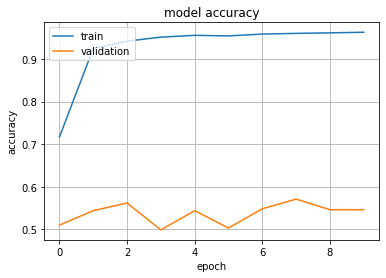

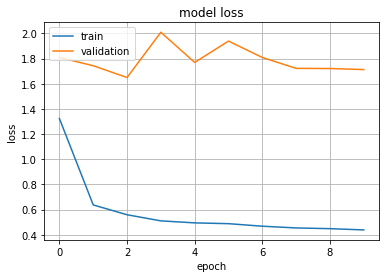

7/7 [==============================] - 0s 10ms/step - loss: 1.7122 - sparse_categorical_accuracy: 0.5463
[1.7121716737747192, 0.5462753772735596]


In [8]:
nf = 40
conv_size = 25
n_dense_connections = 40

model = tf.keras.Sequential()
model.add(layers.Reshape((1, 22, 1000), input_shape=(22, 1000)))
model.add(layers.Conv2D(input_shape=(1, 22, 1000),
                        filters=nf, kernel_size=(1, conv_size), data_format='channels_first',
                        padding='same', activation='relu'))
# model.add(layers.Conv2D(input_shape=(nf, 22, 1000),
#                         filters=nf, kernel_size=(1, conv_size), data_format='channels_first',
#                         padding='same', activation='relu'))
# model.add(layers.Conv2D(input_shape=(nf, 22, 1000),
#                         filters=nf, kernel_size=(1, conv_size), data_format='channels_first',
#                         padding='same', activation='relu'))
model.add(layers.Permute((3, 1, 2)))
model.add(layers.Reshape((1000, nf*22)))
model.add(layers.Dropout(0.1, noise_shape=(1, nf*22)))
model.add(layers.Dense(n_dense_connections, kernel_regularizer='l2', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Lambda(lambda x: K.pow(x, 2)))
model.add(layers.AveragePooling1D(input_shape=(1000, nf*22),
                                  pool_size=75, strides=15))
model.add(layers.Lambda(lambda x: K.log(x + 1e-12)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(40, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(4, activation='softmax', kernel_regularizer='l2'))

model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(
    train_dataset,
    batch_size=128,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback]
)

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Evaluate model on test dataset
print(model.evaluate(test_dataset))

In [6]:
# %tensorboard --logdir logs/fit